# Effect of input on estimated model

# Experiment 5

- How do the estimation results change for different inputs?
- Try filtered white noise
- will use output error model structure
- assume process noise is white Gaussian distributed (not filtered)

In [1]:
import sysid_pem as sid
import numpy as np
import scipy as sp
import control as ct
import matplotlib.pyplot as plt

Data Generating System:
Plant: 
            z^2 - 1.4 z + 0.53
------------------------------------------
z^4 - 1.6 z^3 + 2.01 z^2 - 1.156 z + 0.578

dt = 0.01



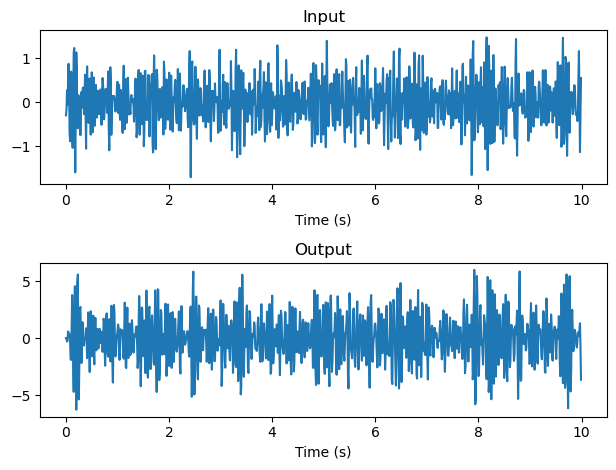

In [9]:
F0 = np.real(np.convolve([1, -0.2+0.8j],np.convolve([1, -0.2-0.8j],np.convolve([1, -0.6+0.7j],[1, -0.6-0.7j]))))
B0 = np.real(np.convolve([1, -0.7+0.2j],[1, -0.7-0.2j]))
 
lamda_v = 1
N = 1000 
Ts = 0.01
Fs = 1/Ts
t = np.linspace(0,10-Ts,N)

G0 = ct.tf(B0,F0,Ts)
#H0 = ct.tf(C0,D0,Ts)
print('Data Generating System:')
print('Plant:', G0)
#print('Noise:', H0)

f0 = 0.3
f1 = 0.5

B,A = sp.signal.butter(1,[f0, f1],btype='bandpass')
u = sp.signal.lfilter(B,A,np.random.randn(N))

tt,y = ct.forced_response(G0,U=u)

fig,ax = plt.subplots(2,1)
ax[0].plot(t,u)
ax[0].set_title('Input')
ax[0].set_xlabel('Time (s)')

ax[1].plot(t,y)
ax[1].set_title('Output')
ax[1].set_xlabel('Time (s)')

fig.tight_layout()

In [10]:
nf = 4
nb = 3
nc = 0
nd = 0
na = nf
nk = 2
n_arx = [na, nb, nk]
n_oe = [nb, nc, nd, nf, nk]


num_iter = 20
V_opt_oe = np.empty(num_iter)
G_est = np.empty(num_iter,dtype=object)
for ii in range(num_iter):
    print('Iteration:',ii)

    e = np.random.randn(N)    
    u = sp.signal.lfilter(B,A,np.random.randn(N))
    tt,y_noise_free = ct.forced_response(G0,U=u)
    y = y_noise_free + lamda_v*e
   
    theta_arx = sid.V_arx_lin_reg(n_arx,y,u)
    theta_oe = np.concatenate((theta_arx[n_arx[0]:n_arx[0]+n_arx[1]],theta_arx[0:n_arx[0]]))  
    optimization_results_oe = sp.optimize.least_squares(sid.V_box_jenkins, theta_oe, jac=sid.jac_V_bj, args=(n_oe,y,u))

    V_opt_oe[ii] = np.sum(optimization_results_oe.fun**2)
    G_est[ii], H_est = sid.theta_2_tf_box_jenkins(optimization_results_oe.x,n_oe,Ts)





Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19


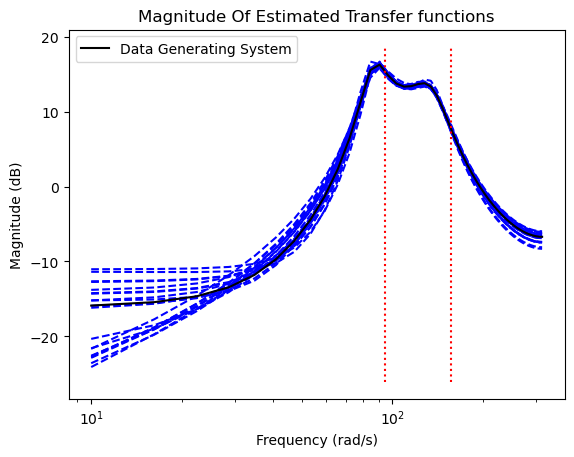

In [11]:

fig,ax = plt.subplots(1)
omega0 = np.linspace(10,100*np.pi)
for ii in range(num_iter):
    mag,phase,omega = ct.bode_plot(G_est[ii],omega=omega0,plot=False)
    ax.semilogx(omega,20*np.log10(mag),'b--',label='_Estimated')
mag,phase,omega = ct.bode_plot(G0,omega=omega0,plot=False)
ax.semilogx(omega,20*np.log10(mag),'k',label='Data Generating System')
ylim = ax.get_ylim()
ax.plot([100*np.pi*f0, 100*np.pi*f0],ylim,'r:',label='_f0')
ax.plot([100*np.pi*f1, 100*np.pi*f1],ylim,'r:',label='_f0')
ax.set_title('Magnitude Of Estimated Transfer functions')
ax.set_ylabel('Magnitude (dB)')
ax.set_xlabel('Frequency (rad/s)')
ax.legend()

# Observations
- The model matches the dynamics of the data generating system plant at the frequencies where the input is non-zero (in the pass band of the filter used to generate the input).
- The models are all very different at frequencies where the input is zero (or close to zero).

# Variance of Estimated Frequency Response

$$
\text{Cov}\Big(\hat{G}_N(e^{j \omega})\Big) \approx \frac{n}{N}\frac{\Phi_v(\omega)}{\Phi_u(\omega)}
$$

where 
$$
\begin{align*}
\Phi_u(\omega) &= \mathcal{F}[R_u(\tau)] \\
&= U(e^{j \omega})U^*(e^{j \omega})
\end{align*}
$$
and
$$
\begin{align*}
\Phi_v(\omega) &= \mathcal{F}[R_v(\tau)] \\
&= V(e^{j \omega})V^*(e^{j \omega})
\end{align*}
$$

Comments:
- This is an approximate expression. 
- Don't actually know $v$, so can't calculate $\Phi_v$. 

What does this expression tell us?

Variance is a function of:
- number of parameters of model
- data length
- noise spectrum
- input spectrum

C:\Users\arne.dankers2\AppData\Local\Temp\ipykernel_9012\2985680191.py:14: RuntimeWarning: invalid value encountered in log10
  ax.semilogx(omega,20*np.log10(mag-np.abs(bound)),':k',label='_bound')


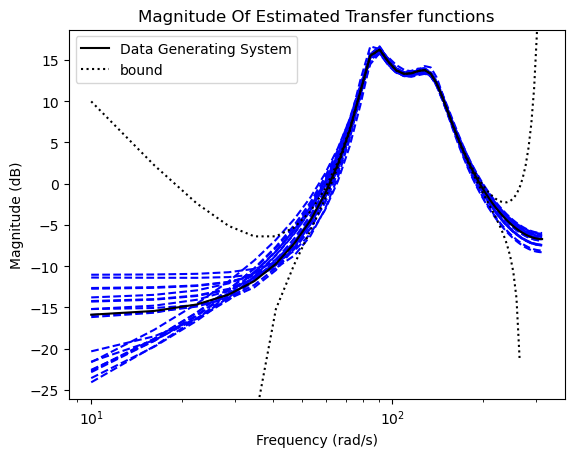

In [13]:

fig,ax = plt.subplots(1)
omega0 = np.linspace(10,100*np.pi)
for ii in range(num_iter):
    mag,phase,omega = ct.bode_plot(G_est[ii],omega=omega0,plot=False)
    ax.semilogx(omega,20*np.log10(mag),'b--',label='_Estimated')
mag,phase,omega = ct.bode_plot(G0,omega=omega0,plot=False)
ax.semilogx(omega,20*np.log10(mag),'k',label='Data Generating System')
ylim = ax.get_ylim()

w,Phi_u = sp.signal.freqz(B,A,worN=omega0,fs=2*100*np.pi)
bound = np.sum(n_oe[0:4])/N*lamda_v**2/Phi_u**2

ax.semilogx(omega,20*np.log10(mag+np.abs(bound)),':k',label='bound')
ax.semilogx(omega,20*np.log10(mag-np.abs(bound)),':k',label='_bound')
ax.set_title('Magnitude Of Estimated Transfer functions')
ax.set_ylabel('Magnitude (dB)')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylim(ylim)
ax.legend()
